<a href="https://colab.research.google.com/github/michaellgoro/colabtogithub/blob/master/shimosaka_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

You can edit this notebook after copying to your drive.  
Click "Playgroundで開く" above and try them!  
  
(C) 2019 Tokyo Institute of Technology All Rights Reserved.  
@author Tatsuya Hiraoka  

In [2]:
# requirement
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cv
import itertools

#SVM
- p19~p22

Text(0, 0.5, 'x2')

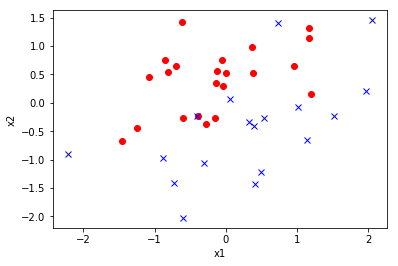

In [ ]:
# data
np.random.seed(777)

n = 40
omega = np.random.randn()
noise = 0.8 * np.random.randn(n)
lam = 0.01

x = np.random.randn(n, 2)
y = 2 * (omega * x[:,0] + x[:,1] + noise > 0) - 1

plt.plot(np.extract(y>0,x[:,0]),np.extract(y>0,x[:,1]), 'ro')
plt.plot(np.extract(y<0,x[:,0]),np.extract(y<0,x[:,1]), 'bx')
plt.xlabel('x1')
plt.ylabel('x2')

Text(0, 0.5, 'loss')

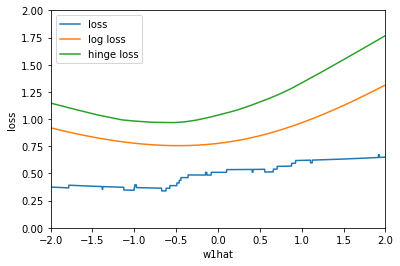

In [ ]:
w1hat = np.arange(-3, 3, 0.002)
lss = np.zeros(len(w1hat))
loglss = np.zeros(len(w1hat))
hingelss = np.zeros(len(w1hat))

for i in range(len(w1hat)):
    reg = lam * (w1hat[i]**2 + 1.0)
    ywx = y * w1hat[i] * x[:,0] + x[:,1]
    lss[i] = 1.0 / n  * np.sum(ywx < 0) + reg
    loglss[i] = 1.0 / n  * np.sum(np.log(1.0 + np.exp(-ywx))) + reg
    hingelss[i] = 1.0 / n * np.sum(np.maximum(np.zeros(len(y)), 1 - ywx)) + reg

plt.plot(w1hat, lss, label='loss')
plt.plot(w1hat, loglss, label='log loss')
plt.plot(w1hat, hingelss, label='hinge loss')
plt.legend()
plt.xlim(-2,2)
plt.ylim(0,2)
plt.xlabel('w1hat')
plt.ylabel('loss')

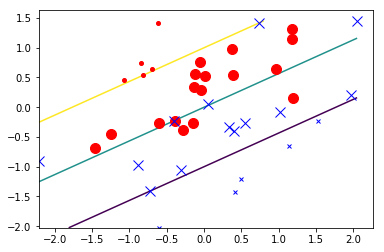

In [ ]:
num_iter = 100
ww = 3
alpha_base = 1
ll_history = []
ww_history = []
what_svm = w1hat[hingelss == np.min(hingelss)]

w = np.vstack([what_svm, [1]])
xi_neq0 = np.where((1.0 - y * (np.dot(x, w)).T) >= 0)[1]
grad = 1.0 / n * np.sum(np.dot(-y[xi_neq0], x[xi_neq0])) + 2 * lam * what_svm

x1 = np.arange(np.min(x[:,0]), np.max(x[:,0]), 0.01)
x2 = np.arange(np.min(x[:,1]), np.max(x[:,1]), 0.01)

fvalue = np.zeros((len(x1), len(x2)))

for i in range(len(x1)):
    for j in range(len(x2)):
        inp = np.hstack([x1[i],x2[j]])
        fvalue[i,j] = np.dot(inp, w)

plt.contour(x1, x2, fvalue.T, [-1, 0, 1])
        
for i in range(n):
    if y[i]>0:
        if np.dot(x[i], w)>1:
            plt.plot(x[i,0], x[i,1], 'ro', markersize=4)
        else:
            plt.plot(x[i,0], x[i,1], 'ro', markersize=10)
    else:
        if np.dot(x[i], w)<-1:
            plt.plot(x[i,0], x[i,1], 'bx', markersize=4)
        else:
            plt.plot(x[i,0], x[i,1], 'bx', markersize=10)

# linear regression

In [ ]:
np.random.seed(1)

n = 100
d = 300
Xtr = np.random.randn(n, d)
nai = 10
w = np.vstack([0.7 * np.random.randn(nai, 1) + 3,
              np.zeros((d - nai, 1))])

sigma = 0.2
ytr = np.dot(Xtr, w) + np.random.randn(n, 1) * sigma

Xte = np.random.randn(n, d); 
yte = np.dot(Xte, w) + sigma * np.random.randn(n, 1);

lam = np.exp(np.arange(-2,3,0.25))

len_lam = len(lam)            
tr_error = np.zeros((len_lam, 1))
param_error = np.zeros((len_lam, 1))
pred_error = np.zeros((len_lam, 1))

tr_error_lasso = np.zeros((len_lam, 1))
reg_error_lasso = np.zeros((len_lam, 1))
lpnorm_lasso = np.zeros((len_lam, 1))

param_error_lasso = param_error
pred_error_lasso = pred_error
param_lasso_history = np.zeros((len_lam, d))


In [ ]:

for l in range(len(lam)):         
    a = np.dot(Xtr.T, Xtr) + lam[l] * np.eye(d)
    b = np.dot(np.linalg.matrix_power(a, -1), Xtr.T)
    w_ridge = np.dot(b, ytr)   
               
    param_error[l] = np.linalg.norm(w - w_ridge, 2.0)
    pred_error[l] = np.sum(np.dot(Xte, w_ridge) - yte)**2 / n
    tr_error[l] = np.sum(np.dot(Xtr, w_ridge) - ytr)**2 / n
    
    # cvx
    w_lasso = cv.Variable((d,1))
    obj_fn = 0.5 * cv.norm((ytr - Xtr * w_lasso), 2)**2 + lam[l] * cv.sum(cv.abs(w_lasso))
    objective = cv.Minimize(obj_fn)
    constraints = []
    prob = cv.Problem(objective, constraints)
    result = prob.solve(solver=cv.CVXOPT) 
    
    w_lasso = w_lasso.value
    
    tr_error_lasso[l] = np.sum(np.dot(Xtr, w_lasso) - ytr)**2 / n
    lpnorm_lasso[l] = np.sum(np.abs(w_lasso)**0.01)
    
    reg_error_lasso[l] = np.sum(np.dot(Xtr, w_lasso) - ytr)**2 / n + lam[l] * lpnorm_lasso[l]
      
    pred_error_lasso[l] = np.sum((np.dot(Xte, w_lasso) - yte)**2) / n
    param_error_lasso[l] = np.linalg.norm(w - w_lasso, 2.0)
    param_lasso_history[l] = w_lasso.T

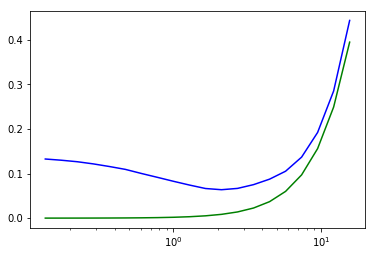

In [ ]:
# # error_tr_te_ridge
plt.semilogx(lam, pred_error, 'b-')
plt.semilogx(lam, tr_error, 'g-')

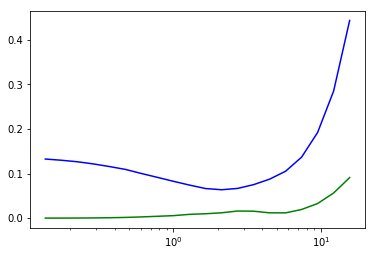

In [ ]:
# error_tr_te_lasso
plt.semilogx(lam, pred_error_lasso, 'b-')
plt.semilogx(lam, tr_error_lasso, 'g-')

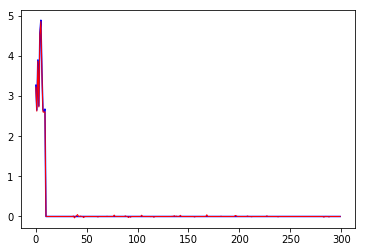

In [ ]:
# param_gt_vs_lasso_best
plt.plot(w, 'b-')
plt.plot(param_lasso_history[np.where(pred_error_lasso == np.min(pred_error_lasso))[0]][0], 'r-', linewidth=1)

(-2, 4)

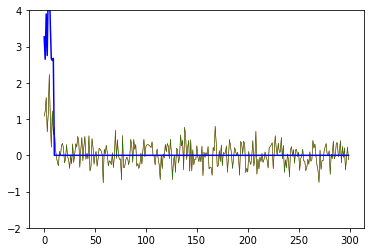

In [ ]:
# param_gt_vs_ridge_best
i = np.where(pred_error == min(pred_error))[0][0]
w_ridge_best = np.dot(np.dot(np.linalg.matrix_power((np.dot(Xtr.T, Xtr) + lam[i] * np.eye(d)), -1), Xtr.T), ytr)
w_ridge_best2 = np.dot(np.dot(np.linalg.matrix_power((np.dot(Xtr.T, Xtr) + lam[13] * np.eye(d)), -1), Xtr.T), ytr)
           
plt.plot(w_ridge_best, 'r-', linewidth=0.5)
plt.plot(w_ridge_best2, 'g-', linewidth=0.5)
plt.plot(w, 'b-');
plt.ylim(-2,4)

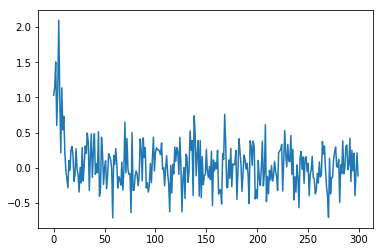

In [ ]:
plt.plot(w_ridge)

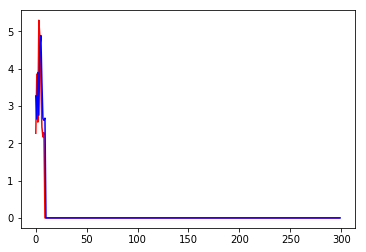

In [ ]:
# param_gt_vs_l0_best

def mldivide(A, b):
  piA = np.linalg.pinv(A)
  x = np.dot(piA, b)
  return x

w_l0_best = np.vstack([mldivide(Xtr[:,1:nai], ytr), np.zeros((d-nai,1))])

plt.plot(w_l0_best, 'r-')
plt.plot(w, 'b-')


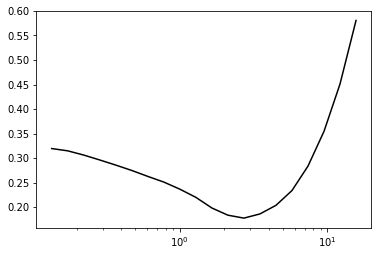

In [ ]:
# param error ridge
plt.semilogx(lam, param_error, 'k-')

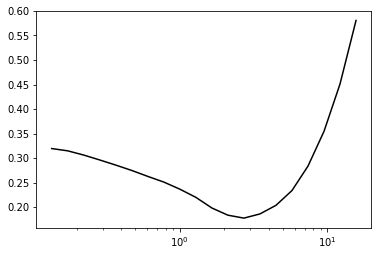

In [ ]:
# param_error_lasso
plt.semilogx(lam, param_error_lasso, 'k-');

In [ ]:
err_l0 = np.zeros((nai * 15, 1))
err_true = np.zeros((nai * 15, 1))
param_err = np.zeros((nai * 15, 1))

nai_ar = np.arange(nai)

for i in range(nai):
    cs = np.array(list(itertools.combinations(nai_ar, i+1)))
    err_l0_with_i = np.zeros((len(cs), 1))
    
    for j in  range(len(cs)):
        Xtr_l0 = Xtr[:, cs[j, :]]
        
        w_l0 = mldivide(Xtr_l0, ytr)
        err_l0_with_i[j] = np.sum((np.dot(Xtr_l0, w_l0) - ytr)**2) / n
   
    err_l0[i] = np.min(err_l0_with_i);
    best_indices = cs[np.where(err_l0_with_i == np.min(err_l0_with_i))[0][0], :]
    Xtr_l0 = Xtr[:, best_indices]
    w_0_best = mldivide(Xtr_l0, ytr)
    Xte_l0 = Xte[:, best_indices]
    err_true[i] = np.sum((yte - np.dot(Xte_l0, w_0_best))**2) / n
    param_err[i] = np.linalg.norm(w - np.vstack([w_0_best, np.zeros((d-i-1,1))]), 2.0)

for i in range(nai+1, nai*15):
    Xtr_l0 = Xtr[:, :i]
    w_l0 = np.dot(np.dot(np.linalg.matrix_power((np.dot(Xtr_l0.T, Xtr_l0) + 0.001 * np.eye(i)), -1), Xtr_l0.T), ytr)
    err_l0[i] = np.sum((np.dot(Xtr_l0, w_l0) - ytr)**2) / n
    Xte_l0 = Xte[:, :i]
    err_true[i] = np.sum((yte - np.dot(Xte_l0, w_l0))**2) / n;
    param_err[i] = np.linalg.norm(w - np.vstack([w_l0, np.zeros((d-i,1))]), 2.0)


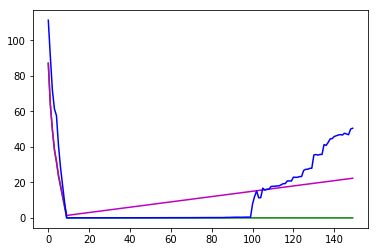

In [ ]:
# l0_rerm
lambda_empirical = 0.15

# rer: regularized empirical risk
rer = err_l0.T[0] + lambda_empirical * np.arange(len(err_l0)).T

plt.plot(err_l0, 'g-')
plt.plot(rer, 'm-')
plt.plot(err_true, 'b-')

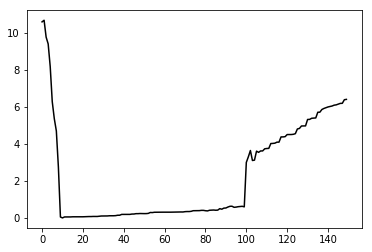

In [ ]:
# param error l0
plt.plot(param_err, 'k-')

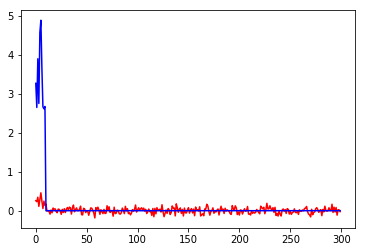

In [ ]:
w_ridge_inf = np.dot(np.linalg.matrix_power((np.dot(Xtr.T, Xtr) + 1000 * np.eye(d)), -1), np.dot(Xtr.T, ytr))
plt.plot(w_ridge_inf, 'r-')
plt.plot(w, 'b-')


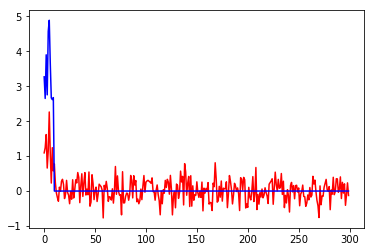

In [ ]:
# w_ridge_min
w_ridge_min = np.dot(np.linalg.matrix_power((np.dot(Xtr.T, Xtr) + 10e-10 * np.eye(d)), -1), np.dot(Xtr.T, ytr))
plt.plot(w_ridge_min, 'r-')
plt.plot(w, 'b-')

# l1 constraint

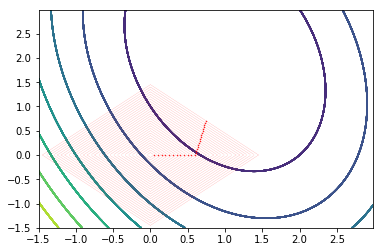

In [ ]:
x_1 = np.arange(-1.5,3,0.01)
x_2 = np.arange(-1.5,3,0.02)
X1, X2 = np.mgrid[-1.5:3:0.01, -1.5:3:0.02]

fValue = np.zeros((len(x_1), len(x_2)))
A = np.array([[3, 0.5],[0.5, 1]])
mu = np.array([[1],[2]])

for i in range(len(x_1)):
  for j in range(len(x_2)):
    k = np.vstack([x_1[i], x_2[j]])
    fValue[i,j] = np.dot(np.dot((k-mu).T, A), k-mu) 

for lamb_cvx in np.arange(0.05, 1.5, 0.05):
    x_11 = np.arange(0, lamb_cvx, 0.01)
    
    plt.contour(X1, X2, fValue)
    
    plt.plot(x_11, -x_11 + lamb_cvx, 'r-', linewidth=0.1)
    plt.plot(-x_11, -x_11  + lamb_cvx, 'r-', linewidth=0.1)
    plt.plot(x_11, x_11  - lamb_cvx, 'r-', linewidth=0.1)
    plt.plot(-x_11, x_11 - lamb_cvx, 'r-', linewidth=0.1)

    # cvx
    w_lasso = cv.Variable((2,1))
    obj_fn = cv.quad_form(w_lasso-mu, A)
    objective = cv.Minimize(obj_fn)
    constraints = [cv.norm(w_lasso, 1) <= lamb_cvx]
    prob = cv.Problem(objective, constraints)
    result = prob.solve(solver=cv.CVXOPT) 
    w_lasso = w_lasso.value
    
    plt.plot(w_lasso[0], w_lasso[1],'ro',markersize=0.5)

# proximal gradient

In [4]:
def st_ops(mu, q):
  x_proj = np.zeros(mu.shape)
  for i in range(len(mu)):
    if mu[i] > q:
      x_proj[i] = mu[i] - q
    else:
      if np.abs(mu[i]) < q:
        x_proj[i] = 0
      else:
        x_proj[i] = mu[i] + q; 
  return x_proj

In [5]:
# we need to control this parameter to generate multiple figures
lam = 2;
#lam = 4;
#lam = 6;
#lam = 3.89; 

x_1 = np.arange(-1.5, 3, 0.01)
x_2 = np.arange(-1.5, 3, 0.02)

X1, X2 = np.mgrid[-1.5:3:0.01, -1.5:3:0.02]
fValue = np.zeros((len(x_1), len(x_2)))

A = np.array([[  3, 0.5],
              [0.5,   1]])
mu = np.array([[1],
               [2]])


In [62]:
def pg_method(lam, x_1, x_2, X1, X2, A, mu):

  for i in range(len(x_1)):
    for j in range(len(x_2)):
          inr = np.vstack([x_1[i], x_2[j]])
          fValue[i, j] = np.dot(np.dot((inr-mu).T, A), (inr- mu)) + lam * (np.abs(x_1[i]) + np.abs(x_2[j]))

  # cvx
  w_lasso = cv.Variable((2,1))
  obj_fn = cv.quad_form(w_lasso - mu, A) +  lam * cv.norm(w_lasso, 1)
  objective = cv.Minimize(obj_fn)
  constraints = []
  prob = cv.Problem(objective, constraints)
  result = prob.solve(solver=cv.CVXOPT) 
  w_lasso = w_lasso.value

  plt.contour(X1, X2, fValue)

  x_init = np.array([[ 3],
                    [-1]])
  L = 1.01 * np.max(np.linalg.eig(2 * A)[0])

  x_history = []
  xt = x_init
  for t in range(1000):
    x_history.append(xt.T)
    grad = 2 * np.dot(A, xt-mu)
    xth = xt - 1/L * grad
    xt = st_ops(xth, lam * 1 / L)

  x_history = np.vstack(x_history)
    
  plt.plot(x_history[:,0], x_history[:,1], 'ro-', markersize=3, linewidth=0.5)
  plt.plot(w_lasso[0], w_lasso[1], 'ko')
  plt.xlim(-1.5, 3)
  plt.ylim(-1.5, 3)

  l1_norm = np.zeros((1000,2))
  for t in range(1000):
    l1_norm[t][0] = x_history[t, 0] - w_lasso[0]
    l1_norm[t][1] = x_history[t, 1] - w_lasso[1]
  for_plot = np.zeros(1000)
  for t in range(1000):
    for_plot[t] = abs(l1_norm[t][0]) + abs(l1_norm[t][1])
  plt.figure()
  plt.semilogx(list(range(1,1001)), for_plot)
  plt.title("λ = %d"%lam)

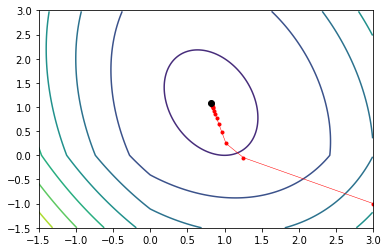

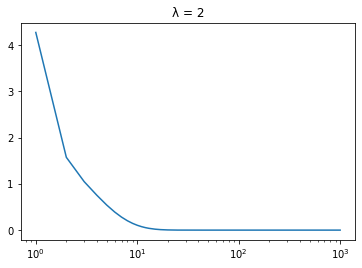

In [63]:
pg_method(2, x_1, x_2, X1, X2, A, mu)

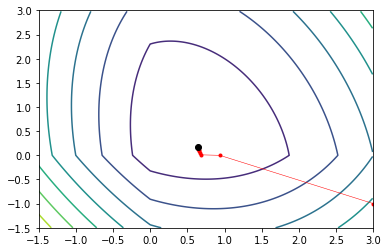

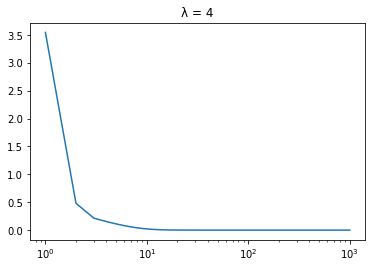

In [64]:
pg_method(4, x_1, x_2, X1, X2, A, mu)

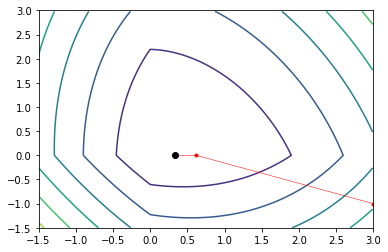

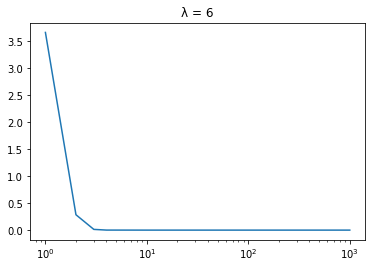

In [65]:
pg_method(6, x_1, x_2, X1, X2, A, mu)

In [58]:
def pg_methods(lams, x_1, x_2, X1, X2, A, mu): #lams には配列で重ねてグラフ表示したいlambdaの値を入れる.

  for lam in lams:
    for i in range(len(x_1)):
      for j in range(len(x_2)):
            inr = np.vstack([x_1[i], x_2[j]])
            fValue[i, j] = np.dot(np.dot((inr-mu).T, A), (inr- mu)) + lam * (np.abs(x_1[i]) + np.abs(x_2[j]))

    # cvx
    w_lasso = cv.Variable((2,1))
    obj_fn = cv.quad_form(w_lasso - mu, A) +  lam * cv.norm(w_lasso, 1)
    objective = cv.Minimize(obj_fn)
    constraints = []
    prob = cv.Problem(objective, constraints)
    result = prob.solve(solver=cv.CVXOPT) 
    w_lasso = w_lasso.value

    plt.contour(X1, X2, fValue)

    x_init = np.array([[ 3],
                      [-1]])
    L = 1.01 * np.max(np.linalg.eig(2 * A)[0])
    
    x_history = []
    xt = x_init
    for t in range(1000):
      x_history.append(xt.T)
      grad = 2 * np.dot(A, xt-mu)
      xth = xt - 1/L * grad
      xt = st_ops(xth, lam * 1 / L)

    x_history = np.vstack(x_history)
      
    plt.plot(x_history[:,0], x_history[:,1], 'ro-', markersize=3, linewidth=0.5)
    plt.plot(w_lasso[0], w_lasso[1], 'ko')
  plt.xlim(-1.5, 3)
  plt.ylim(-1.5, 3)

  # l1_norm = np.zeros((1000,2))
  # for t in range(1000):
  #   l1_norm[t][0] = x_history[t, 0] - w_lasso[0]
  #   l1_norm[t][1] = x_history[t, 1] - w_lasso[1]
  # for_plot = np.zeros(1000)
  # for t in range(1000):
  #   for_plot[t] = abs(l1_norm[t][0]) + abs(l1_norm[t][1])
  # plt.figure()
  # plt.semilogx(list(range(1,1001)), for_plot)

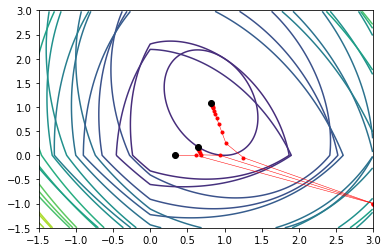

In [59]:
pg_methods([2,4,6],x_1, x_2, X1, X2, A, mu)

(-1.5, 3.0)

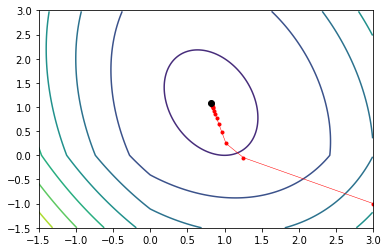

In [6]:

for i in range(len(x_1)):
  for j in range(len(x_2)):
        inr = np.vstack([x_1[i], x_2[j]])
        fValue[i, j] = np.dot(np.dot((inr-mu).T, A), (inr- mu)) + lam * (np.abs(x_1[i]) + np.abs(x_2[j]))

# cvx
w_lasso = cv.Variable((2,1))
obj_fn = cv.quad_form(w_lasso - mu, A) +  lam * cv.norm(w_lasso, 1)
objective = cv.Minimize(obj_fn)
constraints = []
prob = cv.Problem(objective, constraints)
result = prob.solve(solver=cv.CVXOPT) 
w_lasso = w_lasso.value

plt.contour(X1, X2, fValue)

x_init = np.array([[ 3],
                   [-1]])
L = 1.01 * np.max(np.linalg.eig(2 * A)[0])

x_history = []
xt = x_init
for t in range(1000):
  x_history.append(xt.T)
  grad = 2 * np.dot(A, xt-mu)
  xth = xt - 1/L * grad
  xt = st_ops(xth, lam * 1 / L)

x_history = np.vstack(x_history)
  
plt.plot(x_history[:,0], x_history[:,1], 'ro-', markersize=3, linewidth=0.5)
plt.plot(w_lasso[0], w_lasso[1], 'ko')

plt.xlim(-1.5, 3)
plt.ylim(-1.5, 3)

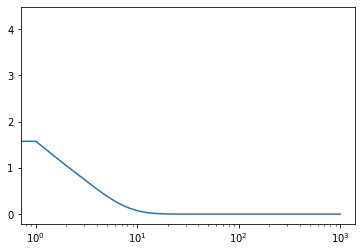

In [32]:
l1_norm = np.zeros((1000,2))
for t in range(1000):
  l1_norm[t][0] = x_history[t, 0] - w_lasso[0]
  l1_norm[t][1] = x_history[t, 1] - w_lasso[1]
for_plot = np.zeros(1000)
for t in range(1000):
  for_plot[t] = abs(l1_norm[t][0]) + abs(l1_norm[t][1])
plt.semilogx(for_plot)
# plt.xscale("log")

(4.272684642863666, 1.5735987398480427)

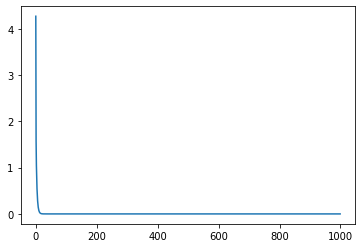

In [31]:
l1_norm = np.zeros((1000,2))
for t in range(1000):
  l1_norm[t][0] = x_history[t, 0] - w_lasso[0]
  l1_norm[t][1] = x_history[t, 1] - w_lasso[1]
for_plot = np.zeros(1000)
for t in range(1000):
  for_plot[t] = abs(l1_norm[t][0]) + abs(l1_norm[t][1])
plt.plot(for_plot)
for_plot[0],for_plot[1]

In [21]:
print("x_history", x_history)
print("w_lasso", w_lasso)
abs()

x_history [[ 3.         -1.        ]
 [ 1.25353265 -0.04738145]
 [ 1.01953548  0.24495024]
 ...
 [ 0.81818182  1.09090909]
 [ 0.81818182  1.09090909]
 [ 0.81818182  1.09090909]]
w_lasso [[0.8181712 ]
 [1.09085585]]


1

In [48]:
s1 = cv.Variable((2,1))
s1
[0:100:1]

SyntaxError: ignored

In [12]:
s1 = s1.value
print(s1)

None


In [13]:
L

6.298428657274788